In [89]:
import copy
import gym
import numpy as np
import scipy.integrate as si
import matplotlib.pyplot as plt
from stable_baselines3 import PPO, DDPG
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.evaluation import evaluate_policy

## Define the swing and set it up as a gym environment

The differential equations which model the swing and the dynamics of changing length are

\begin{equation}
\frac{d}{dt} \left(L^2\dot{\phi}\right) = -gLsin(\phi) \\ 
\tau \dot{L} = -(L - L_0) + L_0 a(t) cos(\phi + \delta(t))
\end{equation}

$\phi(0) = \phi_0, \dot{\phi}(0) = \omega_0, L(0) = L_0$

The first equation is angular momentum balance and the second is the dynamics of the changing length. We control $a(t)$ and $\delta(t)$ so that the swing will reach the target in minimal time.



In [14]:
class Swing(gym.Env):
    def __init__(self, target=np.pi / 2):
        super(Swing, self).__init__()
        self.observation_space = gym.spaces.Box(
            low=np.array([0, -10]), high=np.array([2 * np.pi, 10])
        )

        self.action_space = gym.spaces.Box(
            low=np.array([-1, -1]), high=np.array([1, 1])
        )
        self.target = target
        self.time = 0
        self.dt = 0.5
        self.pumps = 0
        self.phi = [np.pi / 8]
        self.phi_dot = [-1]
        self.L = [1]
        self.a_history = []
        self.d_history = []

    def fun(self, t, y, a, d, L0=1, tau=1, g=9.81):
        y0_dot = y[1]
        y1_dot = (
            -(2 * y[1] / y[2]) * ((y[2] - L0) / tau + y[2] * a * np.cos(y[0] + d) / tau)
            - g * np.sin(y[0]) / y[2]
        )
        y2_dot = -(y[2] - L0) / tau + y[2] * a * np.cos(y[0] + d) / tau
        y_dot = np.hstack((y0_dot, y1_dot, y2_dot))
        return y_dot

    def step(self, action):
        a = action[0]
        self.a_history.append(a)
        d = np.pi * action[1]
        self.d_history.append(d)
        sol = si.solve_ivp(
            self.fun,
            [self.time, self.time + self.dt],
            y0=[self.phi[-1], self.phi_dot[-1], self.L[-1]],
            args=(a, d),
        )
        phi = np.mod(sol.y[0][-1], 2 * np.pi)
        self.phi.append(phi)
        phi_dot = sol.y[1][-1]
        self.phi_dot.append(phi_dot)
        L = sol.y[2][-1]
        self.L.append(L)
        state = np.array([phi, phi_dot])
        if np.isclose(state[0], self.target, rtol=0.1):
            reward = 10
            done = True
            # print("Success! :-)")
        elif self.pumps > 50:
            reward = -1
            done = True
        else:
            reward = -1
            done = False
        info = {}
        self.time += self.dt
        self.pumps += 1
        return state, reward, done, info

    def reset(self):
        self.time = 0
        self.pumps = 0
        self.L = [1]
        self.phi = [np.pi / 8]
        self.phi_dot = [-1]
        state = np.array([self.phi[-1], self.phi_dot[-1]])
        return state

    def render(self):
        pass

## I already trained a model to do the task and it is saved in the "90degswinger" zip

In [90]:
env = Swing()
# model = PPO("MlpPolicy", env, verbose=1)
# model.learn(total_timesteps=2e5)
model = PPO.load("90degswinger.zip", env=env)

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [91]:
obs = env.reset()
done = False
while not done:
    action, _states = model.predict(obs, deterministic=True)
    obs, reward, done, info = env.step(action)
    env.render()

a_actions = copy.deepcopy(env.a_history)
a_actions.insert(0, 0)

d_actions = copy.deepcopy(env.d_history)
d_actions.insert(0, 0)

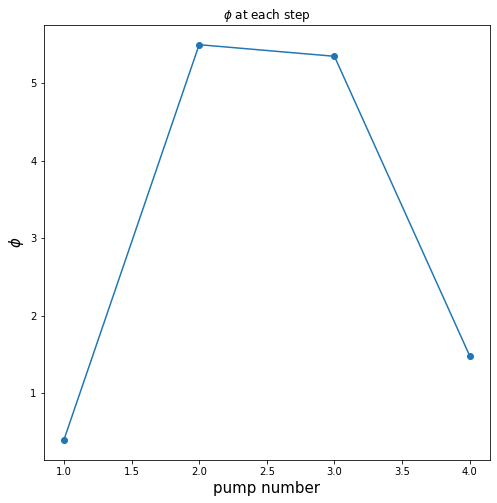

In [105]:
times = np.linspace(1, len(env.phi), len(env.phi))
plt.figure(figsize=(8, 8))
plt.plot(times, env.phi, "-o")
plt.title(r"$\phi$ at each step")
plt.xlabel("pump number", fontsize=15)
plt.ylabel(r"$\phi$", fontsize=15)
plt.yticks
plt.show()

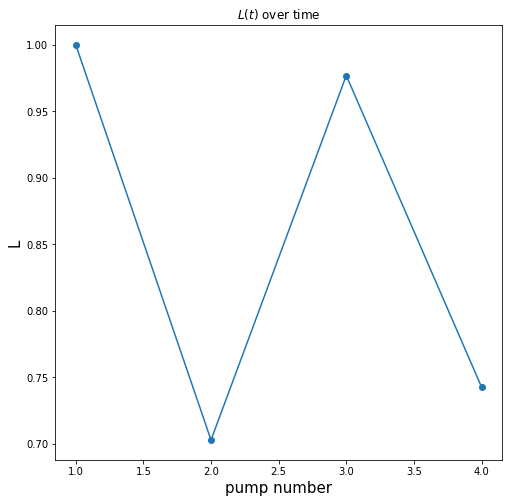

In [111]:
plt.figure(figsize=(8, 8))
plt.plot(times, env.L, "-o")
plt.xlabel("pump number", fontsize=15)
plt.ylabel(r"L", fontsize=15)
plt.title(r"$L(t)$ over time")
plt.show()

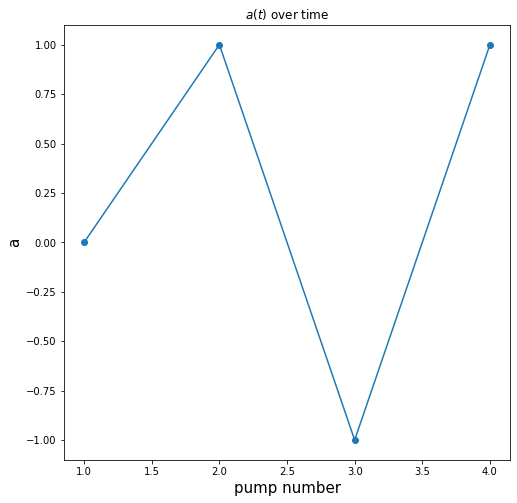

In [106]:
plt.figure(figsize=(8, 8))
plt.plot(times, a_actions, "-o")
plt.xlabel("pump number", fontsize=15)
plt.ylabel("a", fontsize=15)
plt.title(r"$a(t)$ over time")
plt.show()

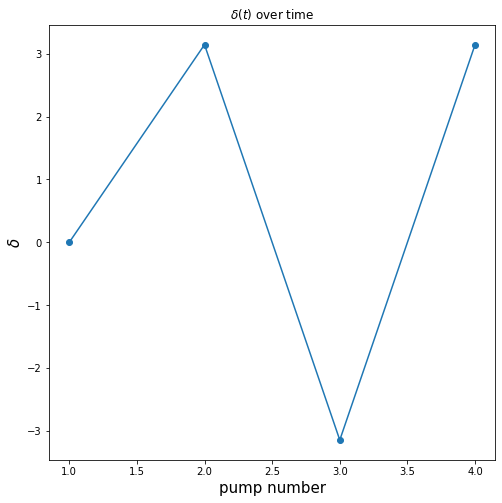

In [107]:
plt.figure(figsize=(8, 8))
plt.plot(times, d_actions, "-o")
plt.xlabel("pump number", fontsize=15)
plt.ylabel(r"$\delta$", fontsize=15)
plt.title(r"$\delta(t)$ over time")
plt.show()